In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import rpy2.robjects as ro
from functools import partial
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
from rpy2.ipython import html
html.html_rdataframe = partial(html.html_rdataframe, table_class = "docutils")
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [64]:
%%R
library(mlbench)
datasetxor <- mlbench.xor(300)
XR_datasetxor <- datasetxor$x
LABELSR_datasetxor<- datasetxor$classes

In [65]:
from rpy2.robjects import numpy2ri
numpy2ri.activate()
x_df_xor = np.array(ro.r['XR_datasetxor'])
labels_df_xor = np.array(ro.r['LABELSR_datasetxor'])
labels_df_xor[labels_df_xor == 1] = -1
labels_df_xor[labels_df_xor == 2] = 1

In [66]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_df_xor, labels_df_xor, random_state = 0, train_size = 0.7)

In [67]:
def train_ELM_DropOut(xin : np.ndarray, yin : np.ndarray, p : int, keep_rate : float, control : bool) -> list:
    np.random.seed(np.random.randint(0, 10000))
    
    
    n = xin.shape[1] # Pegando o número de valores de cada entrada.

    # Z[n ou n + 1, p]
    if control == True:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range((n + 1) * p)]).reshape(n + 1, p)
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin,ones), axis = 1)
    else:
        Z = np.array([np.random.uniform(-0.5, 0.5) for _ in range(n * p)]).reshape(n , p)
        
    #print(Z)
    
    # Técnica de DropOut.
    #D = np.random.rand(Z.shape[0], Z.shape[1])
    #print(f" D : {D}")

    #Z_alter = (Z * D)

    #D = (D < keep_rate)
    #Z_alter = (Z * D)
    #Z_alter = (Z * D) / keep_rate
    #print(Z_alter)
    #print(f" Z_alter : {Z_alter}")
    #Z_alter[ Z_alter < keep_rate] = 0
    #print(f" Z_alter : {Z_alter}")

    Z_alter = Z

    for i in range(Z_alter.shape[1]):
        column = Z_alter[:, i]
        column[column < keep_rate] = 0
        Z_alter[:, i] = column

    #print(Z_alter)


    # A saída da rede é obtida com a pseudoinversa.
    H = np.tanh(np.dot(xin, Z_alter))
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1) 
    w = np.dot(np.linalg.pinv(H), yin)

    # Retornos.
    return_list = list()
    return_list.append(w)   
    return_list.append(H)
    return_list.append(Z) # Conexões são desligadas apenas no treino, portanto tenho que mandar a matriz Z completa.
    return_list.append(Z_alter)
    return  return_list


def test_ELM(xin: np.ndarray, Z: np.ndarray, W: np.ndarray, control: bool):
    
    if control == True:
        ones = np.ones((xin.shape[0], 1))
        xin = np.concatenate((xin, ones), axis = 1)
        
    H = np.tanh(np.dot(xin, Z))
    ones = np.ones((H.shape[0], 1))
    H = np.concatenate((H, ones), axis = 1)
    
    Y_hat = np.sign(np.dot(H, W)) # Para problemas de classificação.
    #Y_hat = np.dot(H, W) # Para problemas de regressão.
    return Y_hat

In [68]:
p_neurons = 100
ret = train_ELM_DropOut(xin = X_train, yin = y_train, p = p_neurons, keep_rate = -0.25, control = True)
wxor = ret[0]
hxor = ret[1]
zxor = ret[2]
z_alter = ret[3]

####                                                   w = H⁺y

In [69]:
hxor

array([[-3.39370542e-01,  2.89178235e-01,  9.62059952e-02, ...,
        -4.07126225e-01, -2.19080244e-01,  1.00000000e+00],
       [ 1.23950480e-02, -2.75281448e-01,  2.57267772e-04, ...,
        -1.15208355e-03, -2.36595194e-01,  1.00000000e+00],
       [-1.53295786e-01,  2.37391443e-02,  4.41476244e-02, ...,
        -1.95287367e-01, -2.28621163e-01,  1.00000000e+00],
       ...,
       [-5.76449279e-02, -1.17204903e-01,  1.87017823e-02, ...,
        -8.35638535e-02, -2.33249789e-01,  1.00000000e+00],
       [ 3.33206894e-01, -7.04491932e-02, -8.74142180e-02, ...,
         3.73475390e-01, -2.52457333e-01,  1.00000000e+00],
       [-1.55479280e-01, -1.91754222e-01,  4.47350361e-02, ...,
        -1.97821262e-01, -2.28514090e-01,  1.00000000e+00]])

In [70]:
np.dot(np.linalg.pinv(hxor), hxor)

array([[ 9.99666775e-01,  4.40608087e-05,  3.43320826e-03, ...,
         7.07977245e-06,  4.05963586e-03,  3.46755981e-03],
       [-2.22346855e-07,  9.99999837e-01,  1.92618419e-07, ...,
        -3.35193411e-07, -1.40319135e-06,  2.62260437e-06],
       [ 3.48178174e-03, -1.95512814e-05,  1.71066539e-01, ...,
        -3.15838789e-04,  8.16956145e-02, -3.56369019e-02],
       ...,
       [ 3.92479390e-05, -2.44683317e-06, -3.74508284e-04, ...,
         9.99994694e-01, -3.32710374e-04, -4.97341156e-04],
       [ 4.06050640e-03, -1.35247457e-05,  8.16949443e-02, ...,
        -3.69324197e-04,  8.64493521e-02, -1.89220428e-01],
       [ 3.74147709e-03, -4.94624433e-05, -3.52380076e-02, ...,
        -4.07672195e-04, -1.89143811e-01,  7.43804932e-01]])

In [71]:
wxor

array([-4.17385196e+07, -6.10838659e+08,  5.85518854e+11, -1.88861619e+11,
        1.77840848e+11,  7.94526326e+11, -3.79748196e+08,  2.24403170e+11,
       -1.09292229e+12,  5.08426035e+08,  4.60596744e+11, -4.91171002e+11,
        3.39665172e+08,  1.51200549e+12, -2.43637724e+12,  2.20226353e+11,
       -8.52727184e+07,  4.37296941e+08, -3.03633671e+04,  1.52205230e+08,
        1.20839032e+11, -4.14797487e+11,  1.54837255e+09,  4.72908817e+08,
       -2.61894005e+11, -3.43862758e+11,  2.86508462e+08,  9.71147690e+06,
       -1.83563907e+07, -1.08605417e+09, -1.42637631e+11, -1.13244651e+11,
        6.22983351e+07, -3.20078048e+11,  6.08101777e+06, -8.70509428e+10,
       -1.84234110e+02, -5.98528387e+07,  1.94437112e+12, -6.17562377e+10,
       -5.92765655e+09, -1.13327661e+10,  8.75054122e+10, -3.51157312e+09,
       -3.69777985e+07,  2.57174642e+11,  6.27176659e+11,  3.58442983e+07,
        1.12617289e+10, -6.54036729e+11, -1.63940981e+07, -1.18522119e+10,
        3.16801551e+10, -

In [72]:
zxor = np.array(zxor)
z_alter = np.array(z_alter)
print(f" There are {len(z_alter[z_alter == 0])} neurons that were droped.")

 There are 75 neurons that were droped.


In [73]:
labels_df_reshaped = labels_df_xor.reshape(-1, 1)
mat_plot = np.concatenate((x_df_xor, labels_df_reshaped), axis = 1)
index_sort = 2
sorted_indices = np.argsort(mat_plot[:, index_sort])
mat_plot = mat_plot[sorted_indices]

[]

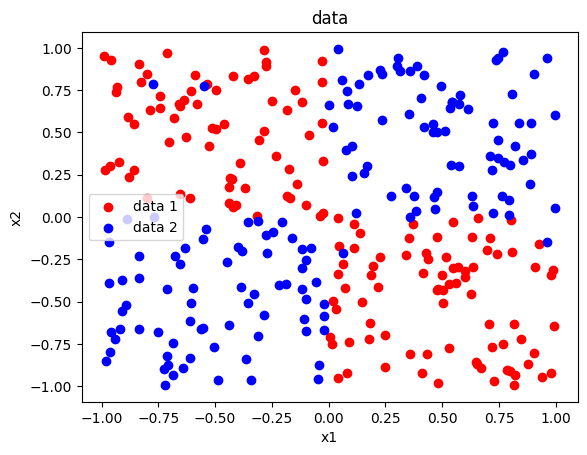

In [74]:
x1_points = mat_plot[: 150, 0 : 2]
x2_points = mat_plot[150 :, 0 : 2]
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data 1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data 2')
plt.title('data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.plot()

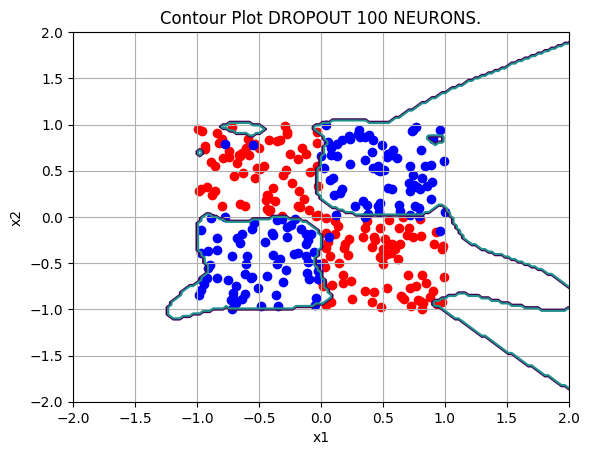

In [75]:
seqx1x2 = np.linspace(start = -4, stop = 4, num = 300)
np_grid = seqx1x2.shape[0]
shape = (np_grid, np_grid)
MZ = np.zeros(shape)
for i in range(np_grid):
    for j in range(np_grid):
        x1 = seqx1x2[i]
        x2 = seqx1x2[j]
        x1x2 = np.column_stack((x1, x2, 1))
        h1 = np.tanh(np.dot(x1x2, zxor))
        h1 = np.column_stack((h1, np.ones_like(h1[:, 0])))
        MZ[i, j] = np.sign(np.dot(h1, wxor))[0]


plt.contour(seqx1x2, seqx1x2, MZ, levels = 1)
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title(f'Contour Plot DROPOUT {p_neurons} NEURONS.')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

In [76]:
from sklearn.metrics import accuracy_score
keep_rate_grid = 0.99
p_neurons_grid = 1000
lst_keep_rate = list()
lst_accuracy = list()
lst_z_val = list()
lst_w_val = list()


while keep_rate_grid > 0 :
    ret_grid = train_ELM_DropOut(xin = X_train, yin = y_train, p = p_neurons_grid, keep_rate = keep_rate_grid, control = True)
    w_grid = ret_grid[0]
    h_grid = ret_grid[1]
    z_grid = ret_grid[2]

    # Testando o modelo.
    y_hatest = test_ELM(X_test, z_grid, w_grid, True)
    accuracy_test = accuracy_score(y_hatest, y_test)

    lst_w_val.append(w_grid)
    lst_z_val.append(z_grid)
    lst_accuracy.append(accuracy_test)
    lst_keep_rate.append(keep_rate_grid)
    keep_rate_grid -= 0.01

In [77]:
lst_accuracy = np.array(lst_accuracy)
lst_w_val = np.array(lst_w_val)
lst_z_val = np.array(lst_z_val)
lst_keep_rate = np.array(lst_keep_rate)
idx = np.argmax(lst_accuracy)

print(f"So, using the keep_rate {lst_keep_rate[idx]} we have the best accuracy that was {lst_accuracy[idx]}.")

So, using the keep_rate 0.37999999999999945 we have the best accuracy that was 0.9111111111111111.


In [78]:
w_plot = np.array(lst_w_val[idx])
z_plot = np.array(lst_z_val[idx])

In [79]:
labels_df_reshaped = labels_df_xor.reshape(-1, 1)
mat_plot = np.concatenate((x_df_xor, labels_df_reshaped), axis = 1)
index_sort = 2
sorted_indices = np.argsort(mat_plot[:, index_sort])
mat_plot = mat_plot[sorted_indices]

[]

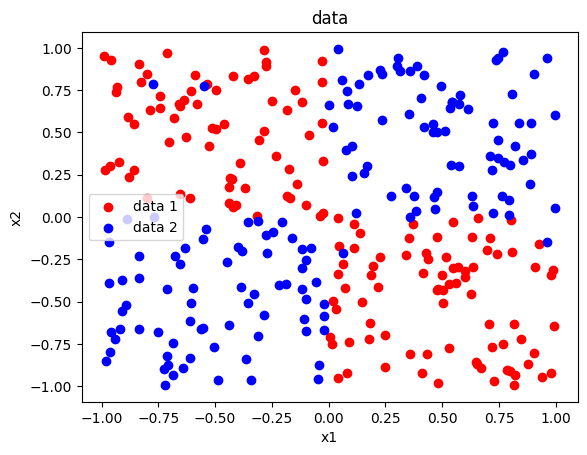

In [80]:
x1_points = mat_plot[: 150, 0 : 2]
x2_points = mat_plot[150 :, 0 : 2]
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data 1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data 2')
plt.title('data')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.plot()

In [81]:
+-seqx1x2 = np.linspace(start = -4, stop = 4, num = 300)
np_grid = seqx1x2.shape[0]
shape = (np_grid, np_grid)
MZ = np.zeros(shape)
for i in range(np_grid):
    for j in range(np_grid):
        x1 = seqx1x2[i]
        x2 = seqx1x2[j]
        x1x2 = np.column_stack((x1, x2, 1))
        h1 = np.tanh(np.dot(x1x2, z_plot))
        h1 = np.column_stack((h1, np.ones_like(h1[:, 0])))
        MZ[i, j] = np.sign(np.dot(h1, w_plot))[0]


plt.contour(seqx1x2, seqx1x2, MZ, levels = 1)
plt.scatter(x1_points[:, 0], x1_points[:, 1], color = 'red', label = 'data1')
plt.scatter(x2_points[:, 0], x2_points[:, 1], color = 'blue', label = 'data2')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot DROPOUT BEST KEEP_RATE')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid(True)
plt.show()

SyntaxError: cannot assign to expression here. Maybe you meant '==' instead of '='? (1576678108.py, line 1)

In [ ]:
import numpy as np

# Define your matrix A
A = np.array([[1, 2],
              [3, 4],
              [5, 6]])

# Calculate the pseudoinverse
A_pseudo_inv = np.linalg.pinv(A)

print("Pseudoinverse of A:")
print(A_pseudo_inv)
